# 데이콘 식수 인원 예측

## 1. 패키지 불러오기

In [1]:
import pandas as pd
import warnings
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pycaret.regression import *
warnings.filterwarnings(action='ignore')
from matplotlib import font_manager, rc
font_path = "C:/Windows/Fonts/gulim.ttc"
font = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font)

## 2. 데이터 불러오기

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
submission = pd.read_csv('sample_submission.csv')

In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1205 entries, 0 to 1204
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   일자              1205 non-null   object 
 1   요일              1205 non-null   object 
 2   본사정원수           1205 non-null   int64  
 3   본사휴가자수          1205 non-null   int64  
 4   본사출장자수          1205 non-null   int64  
 5   본사시간외근무명령서승인건수  1205 non-null   int64  
 6   현본사소속재택근무자수     1205 non-null   float64
 7   조식메뉴            1205 non-null   object 
 8   중식메뉴            1205 non-null   object 
 9   석식메뉴            1205 non-null   object 
 10  중식계             1205 non-null   float64
 11  석식계             1205 non-null   float64
dtypes: float64(3), int64(4), object(5)
memory usage: 113.1+ KB


In [4]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   일자              50 non-null     object 
 1   요일              50 non-null     object 
 2   본사정원수           50 non-null     int64  
 3   본사휴가자수          50 non-null     int64  
 4   본사출장자수          50 non-null     int64  
 5   본사시간외근무명령서승인건수  50 non-null     int64  
 6   현본사소속재택근무자수     50 non-null     float64
 7   조식메뉴            50 non-null     object 
 8   중식메뉴            50 non-null     object 
 9   석식메뉴            50 non-null     object 
dtypes: float64(1), int64(4), object(5)
memory usage: 4.0+ KB


In [5]:
train.head(3)

,일자,요일,본사정원수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,현본사소속재택근무자수,조식메뉴,중식메뉴,석식메뉴,중식계,석식계
0,2016-02-01,월,2601,50,150,238,0.0,모닝롤/찐빵 우유/두유/주스 계란후라이 호두죽/쌀밥 (쌀:국내산) 된장찌개 쥐...,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 오징어찌개 쇠불고기 (쇠고기:호주산) 계란찜 ...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 육개장 자반고등어구이 두부조림 건파래무침 ...",1039.0,331.0
1,2016-02-02,화,2601,50,173,319,0.0,모닝롤/단호박샌드 우유/두유/주스 계란후라이 팥죽/쌀밥 (쌀:국내산) 호박젓국찌...,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 김치찌개 가자미튀김 모둠소세지구이 마늘쫑무...","콩나물밥*양념장 (쌀,현미흑미:국내산) 어묵국 유산슬 (쇠고기:호주산) 아삭고추무...",867.0,560.0
2,2016-02-03,수,2601,56,180,111,0.0,모닝롤/베이글 우유/두유/주스 계란후라이 표고버섯죽/쌀밥 (쌀:국내산) 콩나물국...,"카레덮밥 (쌀,현미흑미:국내산) 팽이장국 치킨핑거 (닭고기:국내산) 쫄면야채무침 ...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 청국장찌개 황태양념구이 (황태:러시아산) 고기...",1017.0,573.0


In [6]:
test.head(3)

,일자,요일,본사정원수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,현본사소속재택근무자수,조식메뉴,중식메뉴,석식메뉴
0,2021-01-27,수,2983,88,182,5,358.0,모닝롤/연유버터베이글 우유/주스 계란후라이/찐계란 단호박죽/흑미밥 우거지국 고기완자...,쌀밥/흑미밥/찰현미밥 대구지리 매운돈갈비찜 오꼬노미계란말이 상추무침 포기김치 양상추...,흑미밥 얼큰순두부찌개 쇠고기우엉볶음 버섯햄볶음 (New)아삭이고추무절임 포기김치
1,2021-01-28,목,2983,104,212,409,348.0,모닝롤/대만샌드위치 우유/주스 계란후라이/찐계란 누룽지탕/흑미밥 황태국 시래기지짐 ...,쌀밥/보리밥/찰현미밥 우렁된장찌개 오리주물럭 청양부추전 수제삼색무쌈 겉절이김치 양상...,충무김밥 우동국물 오징어무침 꽃맛살샐러드 얼갈이쌈장무침 석박지
2,2021-01-29,금,2983,270,249,0,294.0,모닝롤/핫케익 우유/주스 계란후라이/찐계란 오곡죽/흑미밥 매생이굴국 고구마순볶음 양...,쌀밥/흑미밥/찰현미밥 팽이장국 수제돈까스*소스 가자미조림 동초나물무침 포기김치 양상...,흑미밥 물만둣국 카레찜닭 숯불양념꼬지어묵 꼬시래기무침 포기김치


## 3. 데이터 전처리

### 3-1. 데이터 타입 변환
실수형으로 되어있는 '현본사소속재택근무자수','중식계','석식계'를 정수형으로 바꿔주고 문자형으로 되어있는 '일자'를 datetime 형식으로 바꿔준다.

In [7]:
train[['현본사소속재택근무자수', '중식계', '석식계']] = train[['현본사소속재택근무자수', '중식계', '석식계']].astype('int')
test['현본사소속재택근무자수'] = test['현본사소속재택근무자수'].astype('int')

train['일자'] = pd.to_datetime(train['일자'])
test['일자'] = pd.to_datetime(test['일자'])

### 3-2. 변수 추가
- 일자를 년, 월, 일, 주, 요일 단위로 새로운 변수를 만든다.
- 출근,휴가비율,출장비율,야근비율,재택비율,식사가능자수,중식참여율,석식참여율을 기본 변수를 이용하여 연산하고 새로운 변수로 추가한다.

In [8]:
# train
train['년'] = train['일자'].dt.year
train['월'] = train['일자'].dt.month
train['일'] = train['일자'].dt.day
train['주'] = train['일자'].dt.week
train['요일'] = train['일자'].dt.weekday

train['출근'] = train['본사정원수']-(train['본사휴가자수']+train['본사출장자수']+train['현본사소속재택근무자수'])
train['휴가비율'] = train['본사휴가자수']/train['본사정원수']
train['출장비율'] = train['본사출장자수']/train['본사정원수']
train['야근비율'] = train['본사시간외근무명령서승인건수']/train['출근']
train['재택비율'] = train['현본사소속재택근무자수']/train['본사정원수']
train['식사가능자수'] = train['본사정원수'] - train['본사휴가자수'] - train['현본사소속재택근무자수']
train['중식참여율'] = train['중식계'] / train['출근']
train['석식참여율'] = train['석식계'] / train['출근']

In [9]:
# test
test['년'] = test['일자'].dt.year
test['월'] = test['일자'].dt.month
test['일'] = test['일자'].dt.day
test['주'] = test['일자'].dt.week
test['요일'] = test['일자'].dt.weekday

test['출근'] = test['본사정원수']-(test['본사휴가자수']+test['본사출장자수']+test['현본사소속재택근무자수'])
test['휴가비율'] = test['본사휴가자수']/test['본사정원수']
test['출장비율'] = test['본사출장자수']/test['본사정원수']
test['야근비율'] = test['본사시간외근무명령서승인건수']/test['출근']
test['재택비율'] = test['현본사소속재택근무자수']/test['본사정원수']
test['식사가능자수'] = test['본사정원수'] - test['본사휴가자수'] - test['현본사소속재택근무자수']

## 4. 내부 데이터 활용

### 4-1. 석식없는날
- 중식계가 0인 날은 존재하지 않지만 석식계가 0인 날이 존재한다. 따라서 석식이 없는 날에는 1, 석식이 있는 날은 0으로 표시한다. 
- 석식이 없는날은 메뉴가 존재하지 않으므로 석식메뉴가 없는 날을 석식없는날로 판단한다.

In [10]:
# 메뉴 (저녁)
dinner = []
for day in range(len(train)):
    tmp = train.iloc[day, 9].split(' ') # 공백으로 문자열 구분 
    tmp = ' '.join(tmp).split()    # 빈 원소 삭제

    for i in tmp:
        if '(' in i and ':' in i and ')' in i:
            tmp.remove(i)
    
    dinner.append(tmp)

In [11]:
# 메뉴 (저녁)
dinner_test = []
for day in range(len(test)):
    tmp = test.iloc[day, 9].split(' ') # 공백으로 문자열 구분 
    tmp = ' '.join(tmp).split()    # 빈 원소 삭제

    for i in tmp:
        if '(' in i and ':' in i and ')' in i:
            tmp.remove(i)
    
    dinner_test.append(tmp)

In [12]:
def din(x):
    if x == 0:
        a = 1
    else:
        a = 0
    return a

In [13]:
# train
저녁 = pd.DataFrame(dinner)
저녁 = 저녁[[0,1,2,3]]
저녁 = 저녁.fillna(0)
저녁['석식없는날'] = 저녁[3].apply(din)
train = pd.concat([train,저녁['석식없는날']],axis=1)

In [14]:
# test
저녁 = pd.DataFrame(dinner_test)
저녁 = 저녁[[0,1,2,3]]
저녁 = 저녁.fillna(0)
저녁['석식없는날'] = 저녁[3].apply(din)
test = pd.concat([test,저녁['석식없는날']],axis=1)

In [15]:
train[train['석식없는날']==1][['일자','석식메뉴','석식없는날']].head()

,일자,석식메뉴,석식없는날
204,2016-11-30,*,1
224,2016-12-28,*,1
244,2017-01-25,*,1
262,2017-02-22,*,1
281,2017-03-22,*,1


### 4-2. 특식있는날
- 중/석식 메뉴로 쌀밥이나 흑미밥이 있는 날이 대부분이다. 밥이 나오지 않고 다른 메뉴가 나오는 날을 특식으로 간주한다.
- 특식이 나오는 날은 1, 쌀밥이나 흑미밥이 나오는 날은 0으로 설정한다.

In [16]:
# train_중식
a = pd.DataFrame(train[train['중식메뉴'].str.contains('쌀밥/')])
b = pd.DataFrame(train[train['중식메뉴'].str.contains('흑미밥')])
c = pd.merge(a,b,how='outer')
c['중식_밥특']=0
c = c[['일자','중식_밥특']]

merge_outer = pd.merge(train,c, how='left', left_on='일자', right_on='일자')
merge_outer=merge_outer.fillna(1)
merge_outer['중식_밥특']=merge_outer['중식_밥특'].astype('int')


# train_석식
a1 = pd.DataFrame(train[train['석식메뉴'].str.contains('쌀밥/')])
a2 = pd.DataFrame(train[train['석식메뉴'].str.contains('흑미밥')])
b1 = pd.merge(a1,a2,how='outer')
b1['석식_밥특']=0
b1 = b1[['일자','석식_밥특']]

merge_outer = pd.merge(merge_outer,b1, how='left', left_on='일자', right_on='일자')
merge_outer=merge_outer.fillna(1)
merge_outer['석식_밥특']=merge_outer['석식_밥특'].astype('int')
train=merge_outer

In [17]:
# test_중식
a = pd.DataFrame(test[test['중식메뉴'].str.contains('쌀밥/')])
b = pd.DataFrame(test[test['중식메뉴'].str.contains('흑미밥')])
c = pd.merge(a,b,how='outer')
c['중식_밥특']=0
c = c[['일자','중식_밥특']]

outer = pd.merge(test,c, how='left', left_on='일자', right_on='일자')
outer=outer.fillna(1)
outer['중식_밥특']=outer['중식_밥특'].astype('int')

# test_석식
a1 = pd.DataFrame(test[test['석식메뉴'].str.contains('쌀밥/')])
a2 = pd.DataFrame(test[test['석식메뉴'].str.contains('흑미밥')])
b1 = pd.merge(a1,a2,how='outer')
b1['석식_밥특']=0
b1 = b1[['일자','석식_밥특']]

outer1 = pd.merge(outer,b1, how='left', left_on='일자', right_on='일자')
outer1=outer1.fillna(1)
outer1['석식_밥특']=outer1['석식_밥특'].astype('int')

test=outer1

In [18]:
train[['일자','중식메뉴','석식메뉴','중식_밥특','석식_밥특']].head()

,일자,중식메뉴,석식메뉴,중식_밥특,석식_밥특
0,2016-02-01,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 오징어찌개 쇠불고기 (쇠고기:호주산) 계란찜 ...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 육개장 자반고등어구이 두부조림 건파래무침 ...",0,0
1,2016-02-02,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 김치찌개 가자미튀김 모둠소세지구이 마늘쫑무...","콩나물밥*양념장 (쌀,현미흑미:국내산) 어묵국 유산슬 (쇠고기:호주산) 아삭고추무...",0,1
2,2016-02-03,"카레덮밥 (쌀,현미흑미:국내산) 팽이장국 치킨핑거 (닭고기:국내산) 쫄면야채무침 ...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 청국장찌개 황태양념구이 (황태:러시아산) 고기...",1,0
3,2016-02-04,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 쇠고기무국 주꾸미볶음 부추전 시금치나물 ...","미니김밥*겨자장 (쌀,현미흑미:국내산) 우동 멕시칸샐러드 군고구마 무피클 포...",0,1
4,2016-02-05,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 떡국 돈육씨앗강정 (돼지고기:국내산) 우엉잡채...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 차돌박이찌개 (쇠고기:호주산) 닭갈비 (닭고기:...",0,0


### 4-3. 요일별/월별 중석식 참여율 랭크
- 요일별/월별로 중식이나 석식에 참여하는 비율에 차이가 있음을 EDA를 통해 확인하였다.
- 따라서 요일별/ 월별로 각각 중식/석식참여율이 높은 요일 순으로 랭크를 설정하여 준다.

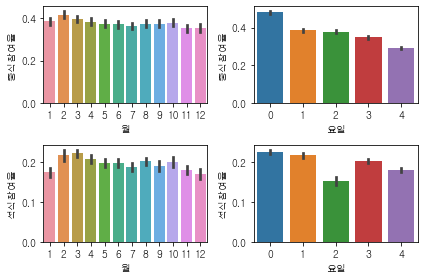

In [19]:
plt.subplot(221)
sns.barplot(x='월', y='중식참여율', data=train)
plt.subplot(222)
sns.barplot(x='요일', y='중식참여율', data=train)
plt.subplot(223)
sns.barplot(x='월', y='석식참여율', data=train, )
plt.subplot(224)
sns.barplot(x='요일', y='석식참여율', data=train)

plt.tight_layout()
plt.show()

In [20]:
# 월별 중식 참여율 랭크
train.groupby(['월']).mean().sort_values(['중식참여율'])

,요일,본사정원수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,현본사소속재택근무자수,중식계,석식계,년,일,주,출근,휴가비율,출장비율,야근비율,재택비율,식사가능자수,중식참여율,석식참여율,석식없는날,중식_밥특,석식_밥특
월,,,,,,,,,,,,,,,,,,,,,,
12,2.029703,2860.207921,218.722772,230.851485,300.683168,61.633663,827.336634,401.168317,2017.930693,15.108911,48.910891,2349.000000,0.075492,0.081145,0.124342,0.020613,2579.851485,0.352200,0.169989,0.039604,0.128713,0.376238
11,2.027778,2850.750000,138.083333,268.120370,290.268519,35.712963,847.333333,434.250000,2017.972222,15.611111,46.250000,2408.833333,0.047844,0.094349,0.119186,0.011822,2676.953704,0.353117,0.180968,0.046296,0.212963,0.370370
7,1.972727,2791.100000,182.763636,246.236364,233.300000,30.618182,848.736364,437.300000,2018.054545,15.990909,28.754545,2331.481818,0.065591,0.088306,0.098676,0.010216,2577.718182,0.363276,0.187795,0.027273,0.200000,0.372727
6,2.088889,2719.766667,121.322222,257.400000,255.633333,21.433333,863.311111,460.355556,2017.733333,15.188889,24.277778,2319.611111,0.044585,0.094736,0.108210,0.007251,2577.011111,0.370985,0.198355,0.044444,0.177778,0.388889
8,2.046729,2910.794393,353.719626,221.981308,234.383178,33.747664,854.785047,459.485981,2017.953271,16.084112,33.168224,2301.345794,0.121764,0.076470,0.100415,0.011291,2523.327103,0.373832,0.201364,0.018692,0.140187,0.392523
9,1.968085,2886.031915,133.904255,246.255319,286.404255,82.159574,907.148936,463.617021,2018.000000,14.808511,37.436170,2423.712766,0.046104,0.086082,0.116574,0.026232,2669.968085,0.374091,0.190858,0.042553,0.127660,0.340426
5,2.020202,2755.818182,143.545455,252.727273,259.131313,44.424242,869.787879,458.131313,2018.000000,17.313131,20.212121,2315.121212,0.052202,0.091889,0.109532,0.014998,2567.848485,0.374196,0.197337,0.030303,0.191919,0.383838
10,1.945652,2858.445652,129.902174,263.369565,304.315217,37.445652,917.771739,481.641304,2018.021739,18.391304,42.239130,2427.728261,0.044939,0.092489,0.124085,0.012449,2691.097826,0.378829,0.199108,0.032609,0.119565,0.347826
4,1.970874,2754.349515,115.271845,243.854369,271.650485,84.330097,883.621359,480.825243,2018.019417,15.310680,15.650485,2310.893204,0.041301,0.089095,0.116612,0.028471,2554.747573,0.382300,0.207919,0.029126,0.155340,0.378641


In [21]:
월별중식랭크 = {2:1,3:2,1:3,4:4,10:5,5:6,9:7,8:8,6:9,7:10,11:11,12:12}

train['월별중식랭크']=train['월'].map(월별중식랭크)
test['월별중식랭크']=test['월'].map(월별중식랭크)

In [22]:
train.groupby(['월별중식랭크']).mean().sort_values(['중식참여율'])

,요일,본사정원수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,현본사소속재택근무자수,중식계,석식계,년,월,일,주,출근,휴가비율,출장비율,야근비율,재택비율,식사가능자수,중식참여율,석식참여율,석식없는날,중식_밥특,석식_밥특
월별중식랭크,,,,,,,,,,,,,,,,,,,,,,,
12,2.029703,2860.207921,218.722772,230.851485,300.683168,61.633663,827.336634,401.168317,2017.930693,12.0,15.108911,48.910891,2349.000000,0.075492,0.081145,0.124342,0.020613,2579.851485,0.352200,0.169989,0.039604,0.128713,0.376238
11,2.027778,2850.750000,138.083333,268.120370,290.268519,35.712963,847.333333,434.250000,2017.972222,11.0,15.611111,46.250000,2408.833333,0.047844,0.094349,0.119186,0.011822,2676.953704,0.353117,0.180968,0.046296,0.212963,0.370370
10,1.972727,2791.100000,182.763636,246.236364,233.300000,30.618182,848.736364,437.300000,2018.054545,7.0,15.990909,28.754545,2331.481818,0.065591,0.088306,0.098676,0.010216,2577.718182,0.363276,0.187795,0.027273,0.200000,0.372727
9,2.088889,2719.766667,121.322222,257.400000,255.633333,21.433333,863.311111,460.355556,2017.733333,6.0,15.188889,24.277778,2319.611111,0.044585,0.094736,0.108210,0.007251,2577.011111,0.370985,0.198355,0.044444,0.177778,0.388889
8,2.046729,2910.794393,353.719626,221.981308,234.383178,33.747664,854.785047,459.485981,2017.953271,8.0,16.084112,33.168224,2301.345794,0.121764,0.076470,0.100415,0.011291,2523.327103,0.373832,0.201364,0.018692,0.140187,0.392523
7,1.968085,2886.031915,133.904255,246.255319,286.404255,82.159574,907.148936,463.617021,2018.000000,9.0,14.808511,37.436170,2423.712766,0.046104,0.086082,0.116574,0.026232,2669.968085,0.374091,0.190858,0.042553,0.127660,0.340426
6,2.020202,2755.818182,143.545455,252.727273,259.131313,44.424242,869.787879,458.131313,2018.000000,5.0,17.313131,20.212121,2315.121212,0.052202,0.091889,0.109532,0.014998,2567.848485,0.374196,0.197337,0.030303,0.191919,0.383838
5,1.945652,2858.445652,129.902174,263.369565,304.315217,37.445652,917.771739,481.641304,2018.021739,10.0,18.391304,42.239130,2427.728261,0.044939,0.092489,0.124085,0.012449,2691.097826,0.378829,0.199108,0.032609,0.119565,0.347826
4,1.970874,2754.349515,115.271845,243.854369,271.650485,84.330097,883.621359,480.825243,2018.019417,4.0,15.310680,15.650485,2310.893204,0.041301,0.089095,0.116612,0.028471,2554.747573,0.382300,0.207919,0.029126,0.155340,0.378641


In [23]:
# 요일별 중식 참여율 랭크
# 중식 참여율에 따라 이미 요일이 매핑되어있기 때문에 따로 매핑해주지 않는다.
train.groupby(['요일']).mean().sort_values(['중식참여율'])

,본사정원수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,현본사소속재택근무자수,중식계,석식계,년,월,일,주,출근,휴가비율,출장비율,야근비율,재택비율,식사가능자수,중식참여율,석식참여율,석식없는날,중식_밥특,석식_밥특,월별중식랭크
요일,,,,,,,,,,,,,,,,,,,,,,,
4,2807.487603,244.809917,273.752066,39.061983,37.123967,653.590909,404.938017,2018.033058,6.553719,15.814050,26.574380,2251.801653,0.086414,0.097899,0.017524,0.012361,2525.553719,0.291554,0.180320,0.012397,0.140496,0.033058,6.623967
3,2805.815574,137.372951,255.577869,379.545082,42.389344,823.991803,480.401639,2018.040984,6.487705,15.934426,26.450820,2370.475410,0.048515,0.091415,0.159247,0.014110,2626.053279,0.349139,0.202962,0.000000,0.016393,0.762295,6.553279
2,2805.690377,113.092050,241.405858,8.209205,45.652720,905.213389,363.615063,2018.050209,6.506276,15.974895,26.682008,2405.539749,0.039850,0.086403,0.003324,0.015199,2646.945607,0.377764,0.152031,0.158996,0.656904,0.213389,6.548117
1,2807.712500,119.004167,230.637500,457.308333,46.737500,925.620833,520.129167,2018.058333,6.483333,16.075000,26.520833,2411.333333,0.041962,0.082491,0.188768,0.015566,2641.970833,0.385381,0.216306,0.004167,0.025000,0.850000,6.516667
0,2812.400000,174.720833,203.829167,485.554167,45.708333,1146.395833,539.533333,2018.079167,6.529167,15.941667,26.629167,2388.141667,0.061663,0.072847,0.200994,0.015246,2591.970833,0.479622,0.225501,0.000000,0.004167,0.025000,6.537500


In [24]:
# 월별 석식 참여율 랭크
train.groupby(['월']).mean().sort_values(['석식참여율'])

,요일,본사정원수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,현본사소속재택근무자수,중식계,석식계,년,일,주,출근,휴가비율,출장비율,야근비율,재택비율,식사가능자수,중식참여율,석식참여율,석식없는날,중식_밥특,석식_밥특,월별중식랭크
월,,,,,,,,,,,,,,,,,,,,,,,
12,2.029703,2860.207921,218.722772,230.851485,300.683168,61.633663,827.336634,401.168317,2017.930693,15.108911,48.910891,2349.000000,0.075492,0.081145,0.124342,0.020613,2579.851485,0.352200,0.169989,0.039604,0.128713,0.376238,12.0
1,1.970297,2823.277228,120.564356,208.415842,249.554455,62.594059,934.247525,424.564356,2018.920792,15.742574,2.811881,2431.702970,0.042732,0.074032,0.101836,0.020989,2640.118812,0.384628,0.174685,0.039604,0.207921,0.376238,3.0
11,2.027778,2850.750000,138.083333,268.120370,290.268519,35.712963,847.333333,434.250000,2017.972222,15.611111,46.250000,2408.833333,0.047844,0.094349,0.119186,0.011822,2676.953704,0.353117,0.180968,0.046296,0.212963,0.370370,11.0
7,1.972727,2791.100000,182.763636,246.236364,233.300000,30.618182,848.736364,437.300000,2018.054545,15.990909,28.754545,2331.481818,0.065591,0.088306,0.098676,0.010216,2577.718182,0.363276,0.187795,0.027273,0.200000,0.372727,10.0
9,1.968085,2886.031915,133.904255,246.255319,286.404255,82.159574,907.148936,463.617021,2018.000000,14.808511,37.436170,2423.712766,0.046104,0.086082,0.116574,0.026232,2669.968085,0.374091,0.190858,0.042553,0.127660,0.340426,7.0
5,2.020202,2755.818182,143.545455,252.727273,259.131313,44.424242,869.787879,458.131313,2018.000000,17.313131,20.212121,2315.121212,0.052202,0.091889,0.109532,0.014998,2567.848485,0.374196,0.197337,0.030303,0.191919,0.383838,6.0
6,2.088889,2719.766667,121.322222,257.400000,255.633333,21.433333,863.311111,460.355556,2017.733333,15.188889,24.277778,2319.611111,0.044585,0.094736,0.108210,0.007251,2577.011111,0.370985,0.198355,0.044444,0.177778,0.388889,9.0
10,1.945652,2858.445652,129.902174,263.369565,304.315217,37.445652,917.771739,481.641304,2018.021739,18.391304,42.239130,2427.728261,0.044939,0.092489,0.124085,0.012449,2691.097826,0.378829,0.199108,0.032609,0.119565,0.347826,5.0
8,2.046729,2910.794393,353.719626,221.981308,234.383178,33.747664,854.785047,459.485981,2017.953271,16.084112,33.168224,2301.345794,0.121764,0.076470,0.100415,0.011291,2523.327103,0.373832,0.201364,0.018692,0.140187,0.392523,8.0


In [25]:
월별석식랭크 = {3:1,2:2,4:3,8:4,10:5,6:6,5:7,9:8,7:9,11:10,1:11,12:12}

train['월별석식랭크']=train['월'].map(월별석식랭크)
test['월별석식랭크']=test['월'].map(월별석식랭크)

In [26]:
train.groupby(['월별석식랭크']).mean().sort_values(['석식참여율'])

,요일,본사정원수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,현본사소속재택근무자수,중식계,석식계,년,월,일,주,출근,휴가비율,출장비율,야근비율,재택비율,식사가능자수,중식참여율,석식참여율,석식없는날,중식_밥특,석식_밥특,월별중식랭크
월별석식랭크,,,,,,,,,,,,,,,,,,,,,,,,
12,2.029703,2860.207921,218.722772,230.851485,300.683168,61.633663,827.336634,401.168317,2017.930693,12.0,15.108911,48.910891,2349.000000,0.075492,0.081145,0.124342,0.020613,2579.851485,0.352200,0.169989,0.039604,0.128713,0.376238,12.0
11,1.970297,2823.277228,120.564356,208.415842,249.554455,62.594059,934.247525,424.564356,2018.920792,1.0,15.742574,2.811881,2431.702970,0.042732,0.074032,0.101836,0.020989,2640.118812,0.384628,0.174685,0.039604,0.207921,0.376238,3.0
10,2.027778,2850.750000,138.083333,268.120370,290.268519,35.712963,847.333333,434.250000,2017.972222,11.0,15.611111,46.250000,2408.833333,0.047844,0.094349,0.119186,0.011822,2676.953704,0.353117,0.180968,0.046296,0.212963,0.370370,11.0
9,1.972727,2791.100000,182.763636,246.236364,233.300000,30.618182,848.736364,437.300000,2018.054545,7.0,15.990909,28.754545,2331.481818,0.065591,0.088306,0.098676,0.010216,2577.718182,0.363276,0.187795,0.027273,0.200000,0.372727,10.0
8,1.968085,2886.031915,133.904255,246.255319,286.404255,82.159574,907.148936,463.617021,2018.000000,9.0,14.808511,37.436170,2423.712766,0.046104,0.086082,0.116574,0.026232,2669.968085,0.374091,0.190858,0.042553,0.127660,0.340426,7.0
7,2.020202,2755.818182,143.545455,252.727273,259.131313,44.424242,869.787879,458.131313,2018.000000,5.0,17.313131,20.212121,2315.121212,0.052202,0.091889,0.109532,0.014998,2567.848485,0.374196,0.197337,0.030303,0.191919,0.383838,6.0
6,2.088889,2719.766667,121.322222,257.400000,255.633333,21.433333,863.311111,460.355556,2017.733333,6.0,15.188889,24.277778,2319.611111,0.044585,0.094736,0.108210,0.007251,2577.011111,0.370985,0.198355,0.044444,0.177778,0.388889,9.0
5,1.945652,2858.445652,129.902174,263.369565,304.315217,37.445652,917.771739,481.641304,2018.021739,10.0,18.391304,42.239130,2427.728261,0.044939,0.092489,0.124085,0.012449,2691.097826,0.378829,0.199108,0.032609,0.119565,0.347826,5.0
4,2.046729,2910.794393,353.719626,221.981308,234.383178,33.747664,854.785047,459.485981,2017.953271,8.0,16.084112,33.168224,2301.345794,0.121764,0.076470,0.100415,0.011291,2523.327103,0.373832,0.201364,0.018692,0.140187,0.392523,8.0


In [27]:
# 요일별 석식참여율 랭크
train.groupby(['요일']).mean().sort_values(['석식참여율'])

,본사정원수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,현본사소속재택근무자수,중식계,석식계,년,월,일,주,출근,휴가비율,출장비율,야근비율,재택비율,식사가능자수,중식참여율,석식참여율,석식없는날,중식_밥특,석식_밥특,월별중식랭크,월별석식랭크
요일,,,,,,,,,,,,,,,,,,,,,,,,
2,2805.690377,113.092050,241.405858,8.209205,45.652720,905.213389,363.615063,2018.050209,6.506276,15.974895,26.682008,2405.539749,0.039850,0.086403,0.003324,0.015199,2646.945607,0.377764,0.152031,0.158996,0.656904,0.213389,6.548117,6.556485
4,2807.487603,244.809917,273.752066,39.061983,37.123967,653.590909,404.938017,2018.033058,6.553719,15.814050,26.574380,2251.801653,0.086414,0.097899,0.017524,0.012361,2525.553719,0.291554,0.180320,0.012397,0.140496,0.033058,6.623967,6.483471
3,2805.815574,137.372951,255.577869,379.545082,42.389344,823.991803,480.401639,2018.040984,6.487705,15.934426,26.450820,2370.475410,0.048515,0.091415,0.159247,0.014110,2626.053279,0.349139,0.202962,0.000000,0.016393,0.762295,6.553279,6.536885
1,2807.712500,119.004167,230.637500,457.308333,46.737500,925.620833,520.129167,2018.058333,6.483333,16.075000,26.520833,2411.333333,0.041962,0.082491,0.188768,0.015566,2641.970833,0.385381,0.216306,0.004167,0.025000,0.850000,6.516667,6.566667
0,2812.400000,174.720833,203.829167,485.554167,45.708333,1146.395833,539.533333,2018.079167,6.529167,15.941667,26.629167,2388.141667,0.061663,0.072847,0.200994,0.015246,2591.970833,0.479622,0.225501,0.000000,0.004167,0.025000,6.537500,6.504167


In [28]:
요일별석식랭크 = {0:0,1:1,2:4,3:2,4:3}

train['요일별석식랭크']=train['요일'].map(요일별석식랭크)
test['요일별석식랭크']=test['요일'].map(요일별석식랭크)

In [29]:
train.groupby(['요일별석식랭크']).mean().sort_values(['석식참여율'])

,요일,본사정원수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,현본사소속재택근무자수,중식계,석식계,년,월,일,주,출근,휴가비율,출장비율,야근비율,재택비율,식사가능자수,중식참여율,석식참여율,석식없는날,중식_밥특,석식_밥특,월별중식랭크,월별석식랭크
요일별석식랭크,,,,,,,,,,,,,,,,,,,,,,,,,
4,2.0,2805.690377,113.092050,241.405858,8.209205,45.652720,905.213389,363.615063,2018.050209,6.506276,15.974895,26.682008,2405.539749,0.039850,0.086403,0.003324,0.015199,2646.945607,0.377764,0.152031,0.158996,0.656904,0.213389,6.548117,6.556485
3,4.0,2807.487603,244.809917,273.752066,39.061983,37.123967,653.590909,404.938017,2018.033058,6.553719,15.814050,26.574380,2251.801653,0.086414,0.097899,0.017524,0.012361,2525.553719,0.291554,0.180320,0.012397,0.140496,0.033058,6.623967,6.483471
2,3.0,2805.815574,137.372951,255.577869,379.545082,42.389344,823.991803,480.401639,2018.040984,6.487705,15.934426,26.450820,2370.475410,0.048515,0.091415,0.159247,0.014110,2626.053279,0.349139,0.202962,0.000000,0.016393,0.762295,6.553279,6.536885
1,1.0,2807.712500,119.004167,230.637500,457.308333,46.737500,925.620833,520.129167,2018.058333,6.483333,16.075000,26.520833,2411.333333,0.041962,0.082491,0.188768,0.015566,2641.970833,0.385381,0.216306,0.004167,0.025000,0.850000,6.516667,6.566667
0,0.0,2812.400000,174.720833,203.829167,485.554167,45.708333,1146.395833,539.533333,2018.079167,6.529167,15.941667,26.629167,2388.141667,0.061663,0.072847,0.200994,0.015246,2591.970833,0.479622,0.225501,0.000000,0.004167,0.025000,6.537500,6.504167


## 5. 외부 데이터 활용

### 5-1. 공휴일전후
- 공휴일이 끼어있는 날은 중식/석식계에 변화가 있을 것이라고 판단하였다.
- 공휴일이 있는 날 전후에는 1로 설정해주고 그렇지 않은 날은 0으로 설정한다.

In [30]:
one=np.ones(146, dtype=int)
공휴일=pd.DataFrame({'일자':['20160205','20160211','20160205','20160229','20160504','20160603','20160812','20160913','20160913',
                        '20160913','20160930','20170126','20170126','20170228','20170428','20170502','20170504','20170508',
                        '20170605','20170814','20170929','20170929','20171222','20171229','20180214','20180214','20180228',
                        '20180504','20180521','20180605','20180612','20180814','20180921','20180921','20180921','20181002',
                        '20181008','20181224','20181231','20190201','20190201','20190201','20190503','20190605','20190814',
                        '20190911','20190911','20191002','20191008','20191224','20191231','20200123','20200123','20200414',
                        '20200504','20200814','20200929','20200929','20200929','20201008','20201224','20201231','20210210',
                        '20210210','20210226','20210504','20210917','20210917','20210917','20160104','20160211','20160211',
                        '20160211','20160302','20160506','20160607','20160816','20160919','20160919','20160919','20161004',
                        '20170131','20170131','20170302','20170502','20170504','20170508','20170510','20170607','20170816',
                        '20171004','20171010','20171010','20171010','20171226','20180102','20180219','20180219','20180302',
                        '20180508', '20180523', '20180607', '20180614', '20180816','20180927','20180927','20180927','20181004',
                        '20181010','20181226','20190102','20190206','20190206','20190207','20190507','20190607','20190816',
                        '20190916','20190916','20191004','20191010','20191226','20200102','20200128','20200128','20200416',
                        '20200506','20200818','20201005','20201005','20201005','20201012','20201228','20210104','20190228',
                        '20190304','20200429','20210215','20210302','20160412','20160414','20190930','20200928','20210506',
                        '20210518','20210520'], '공휴일전후':one})
공휴일.drop_duplicates(['일자'], inplace=True)
공휴일['일자']=pd.to_datetime(공휴일['일자'])

In [31]:
# train
merge_outer = pd.merge(train,공휴일, how='left', left_on='일자', right_on='일자')
merge_outer=merge_outer.fillna(0)
merge_outer['공휴일전후']=merge_outer['공휴일전후'].astype('int')
train11=merge_outer

# test
merge_outer1 = pd.merge(test,공휴일, how='left', left_on='일자', right_on='일자')
merge_outer1=merge_outer1.fillna(0)
merge_outer1['공휴일전후']=merge_outer1['공휴일전후'].astype('int')
test11=merge_outer1

In [32]:
train11[['일자','공휴일전후']].head()

,일자,공휴일전후
0,2016-02-01,0
1,2016-02-02,0
2,2016-02-03,0
3,2016-02-04,0
4,2016-02-05,1


In [33]:
test11[['일자','공휴일전후']].head()

,일자,공휴일전후
0,2021-01-27,0
1,2021-01-28,0
2,2021-01-29,0
3,2021-02-01,0
4,2021-02-02,0


### 5-2. 미세먼지 데이터
- 미세먼지/초미세먼지 농도가 높을 수록 구내식당 이용 비율이 높을 것이라고 가정하였다.
- 미세먼지/초미세먼지 등급에 따라 숫자를 매핑하였다.(좋음:1, 보통:2, 나쁨:3, 매우나쁨:4)
- 데이터 출처: airkorea(https://www.airkorea.or.kr/web/realSearch)

In [34]:
# 데이터 로드
pm1 = pd.read_excel('last_amb_hour_time.xls', skiprows=[0,1,2,3,4],usecols =[0,1,2,3,4])
pm1.columns = ['날짜','미세먼지등급','미세먼지수준','초미세먼지등급','초미세먼지수준']

pm2 = pd.read_excel('last_amb_hour_time (1).xls', skiprows=[0,1,2,3,4],usecols =[0,1,2,3,4])
pm2.columns = ['날짜','미세먼지등급','미세먼지수준','초미세먼지등급','초미세먼지수준']

pm3 = pd.read_excel('last_amb_hour_time (2).xls', skiprows=[0,1,2,3,4],usecols =[0,1,2,3,4])
pm3.columns = ['날짜','미세먼지등급','미세먼지수준','초미세먼지등급','초미세먼지수준']

pm4 = pd.read_excel('last_amb_hour_time (3).xls', skiprows=[0,1,2,3,4],usecols =[0,1,2,3,4])
pm4.columns = ['날짜','미세먼지등급','미세먼지수준','초미세먼지등급','초미세먼지수준']

pm5 = pd.read_excel('last_amb_hour_time (4).xls', skiprows=[0,1,2,3,4],usecols =[0,1,2,3,4])
pm5.columns = ['날짜','미세먼지등급','미세먼지수준','초미세먼지등급','초미세먼지수준']

pm6 = pd.read_excel('last_amb_hour_time (5).xls', skiprows=[0,1,2,3,4],usecols =[0,1,2,3,4])
pm6.columns = ['날짜','미세먼지등급','미세먼지수준','초미세먼지등급','초미세먼지수준']

pm7 = pd.read_excel('last_amb_hour_time (6).xls', skiprows=[0,1,2,3,4],usecols =[0,1,2,3,4])
pm7.columns = ['날짜','미세먼지등급','미세먼지수준','초미세먼지등급','초미세먼지수준']

pm8 = pd.read_excel('last_amb_hour_time (7).xls', skiprows=[0,1,2,3,4],usecols =[0,1,2,3,4])
pm8.columns = ['날짜','미세먼지등급','미세먼지수준','초미세먼지등급','초미세먼지수준']

pm9 = pd.read_excel('last_amb_hour_time (8).xls', skiprows=[0,1,2,3,4],usecols =[0,1,2,3,4])
pm9.columns = ['날짜','미세먼지등급','미세먼지수준','초미세먼지등급','초미세먼지수준']

pm10 = pd.read_excel('last_amb_hour_time (9).xls', skiprows=[0,1,2,3,4],usecols =[0,1,2,3,4])
pm10.columns = ['날짜','미세먼지등급','미세먼지수준','초미세먼지등급','초미세먼지수준']

pm11 = pd.read_excel('last_amb_hour_time (10).xls', skiprows=[0,1,2,3,4],usecols =[0,1,2,3,4])
pm11.columns = ['날짜','미세먼지등급','미세먼지수준','초미세먼지등급','초미세먼지수준']

pm12 = pd.read_excel('last_amb_hour_time (11).xls', skiprows=[0,1,2,3,4],usecols =[0,1,2,3,4])
pm12.columns = ['날짜','미세먼지등급','미세먼지수준','초미세먼지등급','초미세먼지수준']

pm13 = pd.read_excel('last_amb_hour_time (12).xls', skiprows=[0,1,2,3,4],usecols =[0,1,2,3,4])
pm13.columns = ['날짜','미세먼지등급','미세먼지수준','초미세먼지등급','초미세먼지수준']

pm14 = pd.read_excel('last_amb_hour_time (13).xls', skiprows=[0,1,2,3,4],usecols =[0,1,2,3,4])
pm14.columns = ['날짜','미세먼지등급','미세먼지수준','초미세먼지등급','초미세먼지수준']

pm15 = pd.read_excel('last_amb_hour_time (14).xls', skiprows=[0,1,2,3,4],usecols =[0,1,2,3,4])
pm15.columns = ['날짜','미세먼지등급','미세먼지수준','초미세먼지등급','초미세먼지수준']

pm16 = pd.read_excel('last_amb_hour_time (15).xls', skiprows=[0,1,2,3,4],usecols =[0,1,2,3,4])
pm16.columns = ['날짜','미세먼지등급','미세먼지수준','초미세먼지등급','초미세먼지수준']

pm17 = pd.read_excel('last_amb_hour_time (16).xls', skiprows=[0,1,2,3,4],usecols =[0,1,2,3,4])
pm17.columns = ['날짜','미세먼지등급','미세먼지수준','초미세먼지등급','초미세먼지수준']

pm18 = pd.read_excel('last_amb_hour_time (17).xls', skiprows=[0,1,2,3,4],usecols =[0,1,2,3,4])
pm18.columns = ['날짜','미세먼지등급','미세먼지수준','초미세먼지등급','초미세먼지수준']

pm19 = pd.read_excel('last_amb_hour_time (18).xls', skiprows=[0,1,2,3,4],usecols =[0,1,2,3,4])
pm19.columns = ['날짜','미세먼지등급','미세먼지수준','초미세먼지등급','초미세먼지수준']

pm20 = pd.read_excel('last_amb_hour_time (19).xls', skiprows=[0,1,2,3,4],usecols =[0,1,2,3,4])
pm20.columns = ['날짜','미세먼지등급','미세먼지수준','초미세먼지등급','초미세먼지수준']

pm21 = pd.read_excel('last_amb_hour_time (20).xls', skiprows=[0,1,2,3,4],usecols =[0,1,2,3,4])
pm21.columns = ['날짜','미세먼지등급','미세먼지수준','초미세먼지등급','초미세먼지수준']

pm22 = pd.read_excel('last_amb_hour_time (21).xls', skiprows=[0,1,2,3,4],usecols =[0,1,2,3,4])
pm22.columns = ['날짜','미세먼지등급','미세먼지수준','초미세먼지등급','초미세먼지수준']

pm23 = pd.read_excel('last_amb_hour_time (22).xls', skiprows=[0,1,2,3,4],usecols =[0,1,2,3,4])
pm23.columns = ['날짜','미세먼지등급','미세먼지수준','초미세먼지등급','초미세먼지수준']

pm24 = pd.read_excel('last_amb_hour_time (23).xls', skiprows=[0,1,2,3,4],usecols =[0,1,2,3,4])
pm24.columns = ['날짜','미세먼지등급','미세먼지수준','초미세먼지등급','초미세먼지수준']

pm25 = pd.read_excel('last_amb_hour_time (24).xls', skiprows=[0,1,2,3,4],usecols =[0,1,2,3,4])
pm25.columns = ['날짜','미세먼지등급','미세먼지수준','초미세먼지등급','초미세먼지수준']

pm26 = pd.read_excel('last_amb_hour_time (25).xls', skiprows=[0,1,2,3,4],usecols =[0,1,2,3,4])
pm26.columns = ['날짜','미세먼지등급','미세먼지수준','초미세먼지등급','초미세먼지수준']

pm27 = pd.read_excel('last_amb_hour_time (26).xls', skiprows=[0,1,2,3,4],usecols =[0,1,2,3,4])
pm27.columns = ['날짜','미세먼지등급','미세먼지수준','초미세먼지등급','초미세먼지수준']

pm28 = pd.read_excel('last_amb_hour_time (27).xls', skiprows=[0,1,2,3,4],usecols =[0,1,2,3,4])
pm28.columns = ['날짜','미세먼지등급','미세먼지수준','초미세먼지등급','초미세먼지수준']

pm29 = pd.read_excel('last_amb_hour_time (28).xls', skiprows=[0,1,2,3,4],usecols =[0,1,2,3,4])
pm29.columns = ['날짜','미세먼지등급','미세먼지수준','초미세먼지등급','초미세먼지수준']

pm30 = pd.read_excel('last_amb_hour_time (29).xls', skiprows=[0,1,2,3,4],usecols =[0,1,2,3,4])
pm30.columns = ['날짜','미세먼지등급','미세먼지수준','초미세먼지등급','초미세먼지수준']

pm31 = pd.read_excel('last_amb_hour_time (30).xls', skiprows=[0,1,2,3,4],usecols =[0,1,2,3,4])
pm31.columns = ['날짜','미세먼지등급','미세먼지수준','초미세먼지등급','초미세먼지수준']

pm32 = pd.read_excel('last_amb_hour_time (31).xls', skiprows=[0,1,2,3,4],usecols =[0,1,2,3,4])
pm32.columns = ['날짜','미세먼지등급','미세먼지수준','초미세먼지등급','초미세먼지수준']

pm33 = pd.read_excel('last_amb_hour_time (32).xls', skiprows=[0,1,2,3,4],usecols =[0,1,2,3,4])
pm33.columns = ['날짜','미세먼지등급','미세먼지수준','초미세먼지등급','초미세먼지수준']

In [35]:
pm1

,날짜,미세먼지등급,미세먼지수준,초미세먼지등급,초미세먼지수준
0,2016-03-31:24,나쁨,125.0,매우나쁨,82.0
1,2016-03-31:23,나쁨,135.0,매우나쁨,86.0
2,2016-03-31:22,나쁨,132.0,매우나쁨,82.0
3,2016-03-31:21,나쁨,122.0,나쁨,68.0
4,2016-03-31:20,나쁨,113.0,나쁨,61.0
...,...,...,...,...,...
1435,2016-02-01:05,보통,38.0,좋음,13.0
1436,2016-02-01:04,보통,37.0,보통,23.0
1437,2016-02-01:03,보통,33.0,보통,19.0
1438,2016-02-01:02,보통,39.0,보통,19.0


In [36]:
#하나의 데이터프레임으로 표현하기
pm = pd.concat([pm1,pm2,pm3,pm4,pm5,pm6,pm7,pm8,pm9,pm10,pm11,pm12,pm13,pm14,pm15,
                pm16,pm17,pm18,pm19,pm20,pm21,pm22,pm23,pm24,pm25,pm26,pm27,pm28,pm29,pm30,pm31,pm32,pm33])
pm_12=pd.DataFrame(pm[pm['날짜'].str.contains(':12')]) # 점심시간인 12시만 필터링
#저녁시간대인 6시에는 12시와 비슷한 정보를 담고 있기 때문에 12시만을 기준을 필터링한다.

#일자만 다시 표시하기(시간정보 삭제하기)
pm_12['일자'] = pm_12.날짜.str.split(':').str[0] 
pm_12['일자']=pd.to_datetime(pm_12['일자'])

In [37]:
미세먼지 = {'좋음':1,'보통':2,'나쁨':3,'매우나쁨':4} #미세먼지등급 매핑
pm_12['미세먼지']=pm_12['미세먼지등급'].map(미세먼지)
pm_12['초미세먼지']=pm_12['초미세먼지등급'].map(미세먼지)
최종pm = pm_12[['일자','미세먼지','초미세먼지']]

In [38]:
# train
mergepm = pd.merge(train11,최종pm, how='left', left_on='일자', right_on='일자')
mergepm=mergepm.fillna(0)
mergepm['미세먼지']=mergepm['미세먼지'].astype('int')
mergepm['초미세먼지']=mergepm['초미세먼지'].astype('int')
train11=mergepm

# test
mergepmt = pd.merge(test11,최종pm, how='left', left_on='일자', right_on='일자')
mergepmt=mergepmt.fillna(0)
mergepmt['미세먼지']=mergepmt['미세먼지'].astype('int')
mergepmt['초미세먼지']=mergepmt['초미세먼지'].astype('int')
test11=mergepmt

In [39]:
train11[['일자','미세먼지','초미세먼지']].head()

,일자,미세먼지,초미세먼지
0,2016-02-01,1,2
1,2016-02-02,2,2
2,2016-02-03,2,3
3,2016-02-04,4,4
4,2016-02-05,2,3


In [40]:
test11[['일자','미세먼지','초미세먼지']].head()

,일자,미세먼지,초미세먼지
0,2021-01-27,1,1
1,2021-01-28,2,2
2,2021-01-29,1,0
3,2021-02-01,2,2
4,2021-02-02,1,1


### 5-3. 날씨 데이터
- 날씨가 좋지 않으면 구내식당 이용이 더 증가할 것이라고 예상하였다.
- 기온과 강수여부가 중요하게 작용할 것이라고 판단하여 날씨 데이터를 바탕으로 평균기온, 최저기온, 최고기온, 눈비(강수여부) 변수를 만든다.
- 데이처 출처: 기상청(https://data.kma.go.kr/data/grnd/selectAsosRltmList.do?pgmNo=36)

In [41]:
weather = pd.read_csv('기상청진주날씨.csv',usecols =[2,3,4,5,6,7], encoding='cp949')
weather.columns = ['일자','평균기온','최저기온','최고기온','일강수량','일최심적설']
weather=weather.fillna(0)
weather['일자']=pd.to_datetime(weather['일자'])

In [42]:
#데이터와 융합
mergeweather1 = pd.merge(train11,weather, how='left', left_on='일자', right_on='일자')
train11=mergeweather1

mergeweather2 = pd.merge(test11,weather, how='left', left_on='일자', right_on='일자')
test11=mergeweather2

In [43]:
#눈비여부 추가
def rainsnow(x):
    if x>0:
        a=1
    else:
        a=0
    return a 

In [44]:
# train
train11['눈비'] = 0
train11['비'] = train11['일강수량'].apply(rainsnow)
train11['눈'] = train11['일최심적설'].apply(rainsnow)
train11['눈비']=train11['비']+train11['눈']
train11['눈비']=train11['눈비'].apply(rainsnow)
train11 = train11.drop('눈',axis=1)
train11 = train11.drop('비',axis=1)

# test
test11['눈비'] = 0
test11['비'] = test11['일강수량'].apply(rainsnow)
test11['눈'] = test11['일최심적설'].apply(rainsnow)
test11['눈비']=test11['비']+test11['눈']
test11['눈비']=test11['눈비'].apply(rainsnow)
test11 = test11.drop('눈',axis=1)
test11 = test11.drop('비',axis=1)

In [45]:
train11[['일자','평균기온','최저기온','최고기온','눈비']].head()

,일자,평균기온,최저기온,최고기온,눈비
0,2016-02-01,-0.6,-4.1,5.0,0
1,2016-02-02,-2.3,-9.1,6.2,0
2,2016-02-03,-1.7,-9.3,7.7,0
3,2016-02-04,-0.2,-7.7,7.7,0
4,2016-02-05,1.3,-6.5,9.6,0


In [46]:
test11[['일자','평균기온','최저기온','최고기온','눈비']].head()

,일자,평균기온,최저기온,최고기온,눈비
0,2021-01-27,4.1,-1.2,11.4,0
1,2021-01-28,1.4,-3.0,10.7,0
2,2021-01-29,-2.3,-6.0,3.0,0
3,2021-02-01,7.5,4.3,10.6,1
4,2021-02-02,0.4,-5.2,7.5,0


### 6. 변수선정 및 최종 모델링 튜닝
- 조식메뉴, 중식메뉴, 석식메뉴, 일강수량, 일최심적설, 월 변수를 train, test에서 제외한다. 메뉴는 튜닝할 때 사용하지 않을 것이고 일강수량, 일최심적설은 이미 강수 여부로 변수가 만들어져 있다. 월 변수는 중/석식월별랭크를 설정해줬기 때문에 또 사용하지 않는다.
- train에 있는 중식참여율, 석식참여율도 이미 관련 변수가 만들어져있기 때문에 train에서 제외한다.
- 마지막으로 중식계와 석식계에 적용되는 변수가 다르기 때문에 중식 train/test, 석식 train/test를 따로 만들어 준다. 석식에 관련된 변수는 중식계 train/test에서 제거하고 중식에 관련된 변수는 석식계 train/test에서 제거한다. 

In [47]:
drops = ['조식메뉴','중식메뉴','석식메뉴','일강수량','일최심적설','월']
dropss = ['중식참여율','석식참여율']
lunchdrop = ['석식_밥특','월별석식랭크','요일별석식랭크']
dinnerdrop = ['중식_밥특','월별중식랭크','요일']

train11 = train11.drop(drops,axis=1)
train11 = train11.drop(dropss,axis=1)
test11 = test11.drop(drops,axis=1)

lunch = train11.drop('석식계',axis=1)
lunch = lunch.drop(lunchdrop,axis=1) 
lunchtest = test11.drop(lunchdrop,axis=1)

dinner = train11.drop('중식계',axis=1)
dinner = dinner.drop(dinnerdrop,axis=1)
dinnertest = test11.drop(dinnerdrop,axis=1)

### 7. pycaret 튜닝
- pycaret를 이용하여 여러가지 모델로 돌려보고 가장 성능이 좋은 모델을 선택하여 예측한다.
- 중식계의 경우 Gradiant Boosting Regressor가 가장 적합하고 석식계의 경우 Extra Trees Regressor가 가장 적합하다.

In [48]:
# 중식계
reg = setup(data = lunch, target = '중식계',numeric_imputation = 'mean', normalize = True, silent = True , session_id = 5137 )

,Description,Value
0,session_id,5137
1,Target,중식계
2,Original Data,"(1205, 27)"
3,Missing Values,False
4,Numeric Features,20
5,Categorical Features,5
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(843, 45)"


In [49]:
best = compare_models(sort= 'MAE',n_select=1)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
gbr,Gradient Boosting Regressor,67.2733,8067.1922,89.1951,0.8140,0.1107,0.0822,0.1310
xgboost,Extreme Gradient Boosting,69.7823,8706.7553,92.7895,0.7993,0.1161,0.0851,0.5100
lightgbm,Light Gradient Boosting Machine,71.4625,9241.4568,95.4526,0.7857,0.1189,0.0872,0.4890
et,Extra Trees Regressor,71.8537,9818.0275,98.4176,0.7733,0.1253,0.0894,0.2590
rf,Random Forest Regressor,72.4020,9876.1165,98.4233,0.7722,0.1244,0.0896,0.3680
lr,Linear Regression,72.8623,9552.9674,96.8984,0.7778,0.1174,0.0877,2.0850
ridge,Ridge Regression,73.1004,9488.8991,96.5867,0.7794,0.1174,0.0882,0.0130
huber,Huber Regressor,73.2018,9628.7227,97.1358,0.7763,0.1185,0.0883,0.0450
br,Bayesian Ridge,73.3479,9510.5643,96.7315,0.7790,0.1182,0.0887,0.0150
lasso,Lasso Regression,74.5321,9732.3282,97.8682,0.7744,0.1204,0.0905,0.0180


In [50]:
gbr = create_model('gbr', fold = 5)
pred_holdout = predict_model(gbr)
final_model_l = finalize_model(gbr)
pred_esb_l = predict_model(final_model_l, lunchtest)
submission['중식계']=pred_esb_l['Label']

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,71.6144,9300.6802,96.4400,0.7910,0.1267,0.0890
1,68.9031,7770.4416,88.1501,0.8383,0.1083,0.0820
2,59.7398,6842.3199,82.7183,0.8403,0.0980,0.0721
3,74.7291,10522.8294,102.5808,0.7647,0.1282,0.0898
4,65.9888,7523.2687,86.7368,0.7956,0.1050,0.0805
Mean,68.1950,8391.9080,91.3252,0.8060,0.1132,0.0827
SD,5.1234,1334.8162,7.1842,0.0292,0.0121,0.0065


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Gradient Boosting Regressor,64.7992,7129.9938,84.4393,0.8383,0.1084,0.0807


In [51]:
#석식계
reg = setup(data = dinner, target = '석식계',numeric_imputation = 'mean', normalize = True, silent = True,  session_id = 4859 )

,Description,Value
0,session_id,4859
1,Target,석식계
2,Original Data,"(1205, 27)"
3,Missing Values,False
4,Numeric Features,20
5,Categorical Features,5
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(843, 45)"


In [52]:
best = compare_models(sort= 'MAE',n_select=1)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
et,Extra Trees Regressor,45.6307,4202.2665,63.7874,0.7649,0.2479,0.1100,0.2960
rf,Random Forest Regressor,46.0782,4000.2287,62.5295,0.7789,0.2442,0.1124,0.3420
huber,Huber Regressor,46.6346,4263.0108,64.4508,0.7664,0.6532,0.1122,0.0350
gbr,Gradient Boosting Regressor,46.7181,4101.2582,63.3380,0.7769,0.6292,0.1104,0.1490
br,Bayesian Ridge,47.2786,4273.9356,64.7941,0.7641,0.6541,0.1117,0.0120
ridge,Ridge Regression,47.4393,4283.0036,64.8838,0.7634,0.6740,0.1119,0.0220
lightgbm,Light Gradient Boosting Machine,47.8261,4292.7578,64.6651,0.7619,0.5343,0.1152,0.2270
xgboost,Extreme Gradient Boosting,48.7485,4177.0861,64.0530,0.7687,0.6101,0.1155,0.7340
lasso,Lasso Regression,49.8367,4648.5280,67.5800,0.7422,0.7096,0.1198,0.0200
par,Passive Aggressive Regressor,51.1856,5065.2359,70.2820,0.7283,0.6660,0.1235,0.0140


In [53]:
et = create_model('et', fold = 5)
pred_holdout = predict_model(et)
final_model_l = finalize_model(et)
pred_esb_l = predict_model(final_model_l, dinnertest)
submission['석식계']=pred_esb_l['Label']

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,52.9083,6107.2961,78.1492,0.7094,0.4861,0.1388
1,42.6485,3172.9155,56.3286,0.8111,0.1403,0.1033
2,41.7154,3035.7221,55.0974,0.8424,0.1293,0.0992
3,45.9723,4261.1541,65.2775,0.7936,0.4896,0.1105
4,51.1666,4724.0568,68.7318,0.7185,0.1558,0.1152
Mean,46.8822,4260.2289,64.7169,0.7750,0.2802,0.1134
SD,4.4748,1123.2508,8.4824,0.0523,0.1697,0.0139


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,45.5409,4522.9438,67.2528,0.7755,0.3483,0.1021


In [54]:
#예측 결과
submission

,일자,중식계,석식계
0,2021-01-27,999.450593,384.08
1,2021-01-28,908.950086,471.62
2,2021-01-29,624.121665,246.40
3,2021-02-01,1257.438824,509.95
4,2021-02-02,1042.531384,521.36
5,2021-02-03,1051.089786,455.63
6,2021-02-04,992.115231,479.66
7,2021-02-05,715.786836,399.40
8,2021-02-08,1299.719187,637.49
9,2021-02-09,1062.500058,543.64
